# Reinforcement Learning part, HW #4
    Courtesy to Yuanyi Zhong, first designed for IE 534/CS 547 Deep Learning, Fall 2019 at UIUC

We will experiment with the (deep) reinforcement learning algorithms covered in the lecture. In particular, you will implement variants of the popular `DQN` (Deep Q-Network) (1) and `A2C` (Advantage Actor-Critic) (2) algorithms (by the same first author!), and test your implementation on both a small example (CartPole problem). We focus on model-free algorithms rather than model-based ones, because neural nets are easier applicable and more popular nowadays in the model-free setting. (When the system dynamic is known or can be easily inferred, model-based can sometimes do better.)


#### References

- (1) Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A.A., Veness, J., Bellemare, M.G., Graves, A., Riedmiller, M., Fidjeland, A.K., Ostrovski, G. and Petersen, S., 2015. Human-level control through deep reinforcement learning. Nature, 518(7540), p.529.
- (2) Mnih, V., Badia, A.P., Mirza, M., Graves, A., Lillicrap, T., Harley, T., Silver, D. and Kavukcuoglu, K., 2016, June. Asynchronous methods for deep reinforcement learning. In International conference on machine learning (pp. 1928-1937).
- (3) A useful tutorial: https://spinningup.openai.com/en/latest/
- (4) *Useful code references*: https://github.com/deepmind/bsuite; https://github.com/openai/baselines; https://github.com/astooke/rlpyt;



## DQN and A2C on CartPole
***
Before you start, you should bind this Colab notebook with your Google Drive if you are running in Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now check that the following Python libraries are available: `numpy, PyTorch, matplotlib, ffmpeg`. Most of them should be available in Colab / your workstation already. If not, you can install via `conda`/`mamba` in your workstation, or run
```
%pip install <package name>
```
in Google Colab.

You will then have to install `gymnasium` (previously `gym` by OpenAI) **every time** you run this notebook.

In [20]:
# install openai gym
%pip install gymnasium
%pip install gymnasium[classic_control]
# additional imports 
%pip install matplotlib
%pip install tqdm
%pip install moviepy
%pip install pygame
%pip install torch
%pip install torchvision


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: gymnasium[classic_control]
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgra

You should also allow `autoreload`, so that you don't have to restart your kernel everytime you edit the dependent `.py` files.

In [7]:
# enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.1 Code Structure

The code is contains 3 auxiliary python files alongside this notebook:

- `Main.py`: contains the main entry point and training loop
- `Model.py`: constructs the torch neural network modules
- `Algo.py`: implements the DQN and A2C algorithms
- `Replay.py`: implements the experience replay buffer for DQN
- `Env.py`: environment for the experiments

**Some parts of the code `Model.py` and `Algo.py` are left blank for you to complete**. You are not required to modify the other parts (unless, of course, you want to boost the performance!). This is kind of a minimalist implementation, and might be different from the other code on the internet in details. You're welcomed to improve it.

### 1.2 OpenAI gym and CartPole environment
OpenAI developed python package `gym` a while ago to facilitate RL research. `gym` provides a common interface between the program and the environments. For instance, the code cell below will create the CartPole environment. A window will show up when you run the code. The goal is to keep adjusting the cart so that the pole stays in its upright position.

A demo video from OpenAI: http://s3-us-west-2.amazonaws.com/rl-gym-doc/cartpole-no-reset.mp4

`gym` also provides interface to Atari games. However, installing package `atari-py` is not easy on Windows/Mac, so we won't demonstrate it here. More info: http://gym.openai.com/docs/.

In [11]:
# Normally you do not need to run these code.
# These code are here for historical reasons (i.e. run them if you have issues with importing gymnasium).
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# # !pip install gym[atari] > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/nB=ull 2>&1

In [8]:
import gymnasium as gym
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from tqdm import tqdm
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

In [ ]:
# cd to the directory where you store your files
# %cd drive/MyDrive/MCF_Deep_Learning/Problem_Sheet_4_Solution

/content/drive/MyDrive/MCF_Deep_Learning/Problem_Sheet_4_Solution


In [9]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

In [17]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = wrap_env(env)
env.reset()

env.start_video_recorder()

for _ in range(1000):
    state, reward, done, *_ = env.step(env.action_space.sample()) # take a random action

    if done:
      env.close_video_recorder()
      break

Moviepy - Building video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4



t:   0%|          | 0/1 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4
Moviepy - Building video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4


In [18]:
show_video()

### 1.3 Deep Q Learning

A little recap on DQN. We learned from lecture that Q-Learning is a model-free reinforcement learning algorithm. It falls into the off-policy type algorithm since it can utilize past experiences stored in a buffer. It also falls into the (approximate) dynamic programming type algorithm, since it tries to learn an optimal state-action value function using time difference (TD) errors. Q Learning is particularly interesting because it exploits the optimality structure in MDP. It's related to the Hamilton–Jacobi–Bellman equation in classical control.

For MDP
$$
M = (S,A,P,r,\gamma)
$$
where $S$ is the state space, $A$ is the action space, $P$ is the transition dynamic, $r(s,a)$ is a reward function $S\times A \mapsto R$, and $\gamma$ is the discount factor.

The tabular case (when $S,A$ are finite), Q-Learning does the following value iteration update repeatedly when collecting experience $(s_t, a_t, r_t)$ ($\eta$ is the learning rate):
$$
Q^{new}(s_t, a_t) \leftarrow Q^{old}(s_t, a_t) + \eta \left( r_t + \gamma \max_{a'\in A} Q^{old}(s_t, a') - Q^{old}(s_t, a_t) \right) .
$$

With function approximation, meaning model $Q(s,a)$ with a function $Q_{\theta}(s,a)$ parameterized by $\theta$, we arrive at the Fitted Q Iteration (FQI) algorithm, or better known as Deep Q Learning if the function class is neural networks. Q-Learning with neural network as function approximator was known long ago, but it was only recently (year 2013) that DeepMind made this algorithm actually work on Atari games. Deep Q Learning iteratively optimize the following objective:
$$
\theta_{new} \leftarrow \arg\min_{\theta} \mathbb{E}_{(s,a,r,s')\sim D} \left( r + \gamma \max_{a'\in A} Q_{\theta_{old}}(s', a') - Q_{\theta}(s, a) \right)^2  .
$$

Therefore, with a batch of $\{(s^i,a^i,r^i,s'^i)\}_{i=1}^N$ sampled from the replay buffer, we can build a loss function $L$ in pytorch:
$$
L(\theta) = \frac1N \sum_{i=1}^N \left( r^i + \gamma \max_{a'\in A} Q_{\theta_{old}}(s'^i, a') - Q_{\theta}(s^i, a^i) \right)^2
,
$$
and run the usual gradient descent on $\theta$ with a pytorch optimizer.


#### Exploration
Exploration, as the word suggests, refers to explore novel unvisited states in RL. The FQI (or DQN) needs an exploratory datasets to work well. The common way to produce exploratory dataset is through randomization, such as the $\epsilon$-greedy exploration strategy we will implement in this assignment.
- $\epsilon$-greedy exploration:

At training iteration $it$, the agent chooses to play
$$
a = \begin{cases}
\arg\max_a Q_{\theta}(s, a)      &  \text{ with probability $1 - \epsilon_{it}$ },  \\
\text{a random action $a \in A$} &  \text{ with probability $\epsilon_{it}$ }.  \\
\end{cases}
$$
And $\epsilon_{it}$ is annealed, for example, linearly from $1$ to $0.01$ as training progresses until iteration $it_{\text{decay}}$:
$$
\epsilon_{it} = \max\Big\{ 0.01, 1 + (0.01-1)\frac{it}{it_{\text{decay}}} \Big\}.
$$

#### Two Caveats
1. There's an improvement on DQN called Double-DQN with the following loss $L$, which has shown to be empirically more stable than the original DQN loss described above. You may want to implement the improved one in your code:
$$
L(\theta) = \frac1N \sum_{i=1}^N \left( r^i + \gamma Q_{\theta_{old}}\big( s'^i, \arg\max_{a'\in A} Q_{\theta}(s'^i, a' ) \big) - Q_{\theta}(s^i, a^i) \right)^2
.
$$
2. Huber loss (a.k.a smooth L1 loss) is commonly used to reduce the effect of extreme values:
$$
L(\theta) = \frac1N \sum_{i=1}^N \mathsf{Huber}\left( r^i + \gamma Q_{\theta_{old}}\big( s'^i, \arg\max_{a'\in A} Q_{\theta}(s'^i, a' ) \big) - Q_{\theta}(s^i, a^i) \right)
$$
You can look up the pytorch document here: https://pytorch.org/docs/stable/nn.functional.html#smooth-l1-loss

##### Complete the code for the two layered fully connected network class `TwoLayerFCNet` in file `Model.py`
And run the cell below to test the output shape of your module.

In [ ]:
# Put here the path to folder where the auxiliary files are
# import sys
# sys.path.insert(0, "/content/drive/MyDrive/RL-Cartpole")

##### Complete the code for $\epsilon$-greedy exploration strategy in function `DQN.act` in file `Algo.py'
And run the cell below to test it.

In [39]:
## Test code
from Algo import DQN
class Nothing: pass
dummy = Nothing()
dummy.eps_decay = 500000
dummy.eps_start = 1
dummy.eps_end = .01

dummy.num_act_steps = 0
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 1.0 ) < 0.01, "ERROR: compute_epsilon at t=0 should be 1 but got %f!" % eps

dummy.num_act_steps = 250000
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 0.505 ) < 0.01, "ERROR: compute_epsilon at t=250000 should around .505 but got %f!" % eps

dummy.num_act_steps = 500000
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 0.01 ) < 0.01, "ERROR: compute_epsilon at t=500000 should be .01 but got %f!" % eps

dummy.num_act_steps = 600000
eps = DQN.compute_epsilon(dummy)
assert abs( eps - 0.01 ) < 0.01, "ERROR: compute_epsilon after t=500000 should be .01 but got %f!" % eps
print ("Epsilon-greedy test passed!")

Epsilon-greedy test passed!


##### Complete the code for computing the loss function in `DQN.train` in file `Algo.py`
And run the cell below to verify your code decreses the loss value in one iteration.

In [42]:
import numpy as np
from Algo import DQN
class Nothing: pass
dummy_obs_space, dummy_act_space = Nothing(), Nothing()
dummy_obs_space.shape = [10]
dummy_act_space.n = 3

dqn = DQN(dummy_obs_space, dummy_act_space, batch_size=2)

for t in range(3):
    dqn.observe([np.random.randn(10).astype('float32')], [np.random.randint(3)],
                [(np.random.randn(10).astype('float32'), np.random.rand(), False, None)])

b = dqn.replay.cur_batch
loss1 = dqn.train()
dqn.replay.cur_batch = b
loss2 = dqn.train()

print (loss1, '>', loss2, '?')
assert loss2 < loss1, "DQN.train should reduce loss on the same batch"

print ("DQN.train test passed!")

parameters to optimize: [('fc1.weight', torch.Size([128, 10]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([3, 128]), True), ('fc2.bias', torch.Size([3]), True)] 

0.5413520336151123 > 0.5353729724884033 ?
DQN.train test passed!


##### Run DQN on CartPole and plot the learning curve (i.e. averaged episodic reward against env steps).
Your code should be able to achieve **>150** averaged reward in 10000 iterations (20000 simulation steps) in only a few minutes. This is a good indication that the implementation is correct. It's ok that the curve is not always monotonically increasing because of randomness in training.

In [43]:
# %run /content/drive/MyDrive/RL-Cartpole/Main.py  \
%run ./Main.py  \
    --niter 10000   \
    --env CartPole-v1   \
    --algo dqn  \
    --nproc 2   \
    --lr 0.001  \
    --train_freq 1  \
    --train_start 100   \
    --replay_size 20000 \
    --batch_size 64     \
    --discount 0.996    \
    --target_update 1000    \
    --eps_decay 4000    \
    --print_freq 200    \
    --checkpoint_freq 20000 \
    --save_dir cartpole_dqn \
    --log log.txt \
    --parallel_env 0

Namespace(niter=10000, env='CartPole-v1', algo='dqn', nproc=2, lr=0.001, n_hidden_nodes=128, clip=1.0, train_freq=1, train_start=100, batch_size=64, discount=0.996, replay_size=20000, need_critic_scheduler=False, target_update=1000, frame_skip=1, frame_stack=4, eps_decay=4000, ent_coef=0.01, value_coef=0.5, print_freq=200, checkpoint_freq=20000, save_dir='cartpole_dqn/', log='log.txt', load='', parallel_env=0)
observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
running on device cpu
parameters to optimize: [('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([2, 128]), True), ('fc2.bias', torch.Size([2]), True)] 

obses on reset: 2 x (4,) float32
iter    200 |loss   0.01 |n_ep    17 |ep_len   22.8 |ep_rew  22.77 |raw_ep_rew  22.77 |env_step    400 |time 00:00 rem 00:03


/Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/Algo.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  obses = torch.as_tensor(obses, device=self.device, dtype=self.state_dtype)


iter    400 |loss   0.01 |n_ep    37 |ep_len   20.7 |ep_rew  20.67 |raw_ep_rew  20.67 |env_step    800 |time 00:00 rem 00:05
iter    600 |loss   0.01 |n_ep    51 |ep_len   28.3 |ep_rew  28.33 |raw_ep_rew  28.33 |env_step   1200 |time 00:00 rem 00:05
iter    800 |loss   0.01 |n_ep    69 |ep_len   24.1 |ep_rew  24.09 |raw_ep_rew  24.09 |env_step   1600 |time 00:00 rem 00:05
iter   1000 |loss   0.02 |n_ep    90 |ep_len   19.9 |ep_rew  19.93 |raw_ep_rew  19.93 |env_step   2000 |time 00:00 rem 00:05
iter   1200 |loss   0.09 |n_ep   112 |ep_len   18.5 |ep_rew  18.54 |raw_ep_rew  18.54 |env_step   2400 |time 00:00 rem 00:05
iter   1400 |loss   0.02 |n_ep   135 |ep_len   17.4 |ep_rew  17.40 |raw_ep_rew  17.40 |env_step   2800 |time 00:00 rem 00:05
iter   1600 |loss   0.04 |n_ep   157 |ep_len   18.0 |ep_rew  18.00 |raw_ep_rew  18.00 |env_step   3200 |time 00:00 rem 00:05
iter   1800 |loss   0.04 |n_ep   181 |ep_len   15.9 |ep_rew  15.88 |raw_ep_rew  15.88 |env_step   3600 |time 00:01 rem 00:04


In [47]:
import matplotlib.pyplot as plt

def plot_curve(logfile, title=None):
    lines = open(logfile, 'r').readlines()
    lines = [l.split() for l in lines if l[:4] == 'iter']
    steps = [int(l[13]) for l in lines]
    rewards = [float(l[11]) for l in lines]
    plt.plot(steps, rewards)
    plt.xlabel('env steps'); plt.ylabel('avg episode reward'); plt.grid(True)
    if title: plt.title(title)
    plt.show()

The log is saved to `'cartpole_dqn/log.txt'`. Let's plot the running averaged episode reward curve during training:

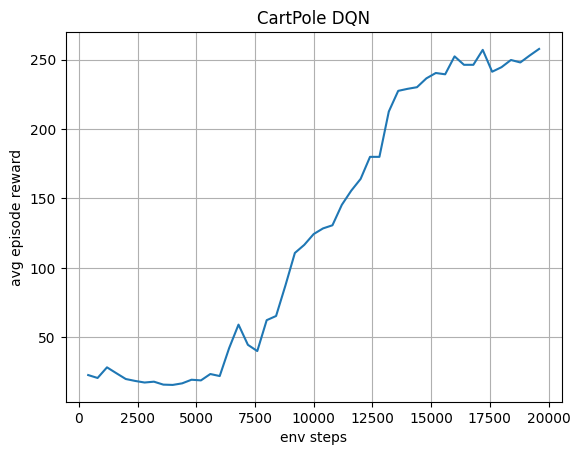

In [48]:
plot_curve('cartpole_dqn/log.txt', 'CartPole DQN')

### 1.4 Actor-Critic Algorithm

Policy gradient methods are another class of algorithms that originated from viewing the RL problem as a mathematical optimization problem. Recall that the objective of RL is to maximize the expected cumulative reward the agent gets, namely
$$
\max_{\pi} J(\pi) := \mathbb{E}_{ (s_t,a_t,r_t)\sim D^{\pi} } \left[ \sum_{t=0}^{\infty} \gamma^t r_t \right]
$$
where $D^{\pi}$ is the distribution of trajectories induced by policy $\pi$, and inside the expectation is the random variable representing the discounted cumulative reward and $J$ is the reward (or cost) functional. Essentially, we want to optimize the policy $\pi$.

The most straightforward way is to run gradient update on the parameter $\theta$ of a *parameterized* policy $\pi_{\theta}$. One such algorithm is the so-called `Advantage Actor-Critic (A2C)`. A2C is an on-policy policy optimization type algorithm. While collecting on-policy data, we iteratively run gradient ascent:
$$
\theta_{new} \leftarrow \theta_{old} + \eta { \hat \nabla_{\theta} } J(\pi_{\theta_{old}})
$$
with a Monte Carlo estimate ${ \hat \nabla_{\theta} } J$ of the true gradient $\nabla_{\theta} J$. The true gradient writes as (by Policy Gradient Theorem and some manipulations):
$$
\nabla_{\theta} J(\pi_{\theta_{old}}) = \mathbb{E}_{ (s_t,a_t,r_t)\sim D^{ \pi_{\theta_{old}} } } \sum_{t=0}^{\infty} \left( \nabla_{\theta} \log \pi_{\theta_{old}} (s_t, a_t) \left( \sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'} - V^{ \pi_{\theta_{old}} }(s_t) \right) \right)  .
$$
The quantity in the inner-most parentheses $A(s_t, a_t) = Q(s_t, a_t) - V(s_t) = (\mathbb{E} \sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'}) - V(s_t)$ is called the *Advantage* function (not very rigoriously speaking...). That's why it's called **Advantage** Actor-Critic. More on A2C: https://arxiv.org/abs/1506.02438.

And the Monte Carlo estimate of the gradient is
$$
{ \hat \nabla_{\theta} } J(\pi_{\theta_{old}}) = \frac1{NT}  \sum_{i=1}^N \sum_{t=0}^T \left( \nabla_{\theta} \log \pi_{\theta_{old}} (s_t^{i}, a_t^{i}) \left( \sum_{t'=t}^T \gamma^{t'-t} r_{t'}^{i} - V_{\phi_{old}}(s_t^{i}) \right) \right)
$$
where $V_{\phi_{old}}$ is introduced as a *parameterized* estimate for $V^{ \pi_{\theta_{old}} }$, which can also be a neural network. So $V_{\phi}$ is the **critic** and $\pi_{\theta}$ is the **actor**. We can construct a specific loss function in pytorch that gives ${ \hat \nabla_{\theta} } J$. $V_{\phi_{old}}$ is trained with SGD on a L2 loss function. It's further common practice to add an entropy bonus loss term to encourage maximum entropy solution, to facilitate exploration and avoid getting stuck in local minima. We shall clarify these loss functions in the following summarization.

#### Summarizing a variant of the A2C algorithm:
> For many iterations repeat:
1. Collect $N$ independent trajectories $\{ (s_t^{i},a_t^{i},r_t^{i})_{t=0}^T \}_{i=1}^{N}$ by running policy $\pi_{\theta}$ for maximum $T$ steps;
2. Compute the loss function for the policy parameter $\theta$:
$$
L_{policy}(\theta) = \frac1{NT} \sum_{i=1}^N \sum_{t=0}^T \left( \log \pi_{\theta} (s_t^{i}, a_t^{i}) \left( \sum_{t'=t}^T \gamma^{t'-t} r_{t'}^{i} - V_{\phi}(s_t^{i}) \right) \right)
$$
Compute the entropy term for $\theta$:
$$
L_{entropy}(\theta) = \frac1{NT} \sum_{i=1}^N \sum_{t=0}^T \left( - \sum_{a\in A} \pi_{\theta}(s_t^{i}, a) \log \pi_{\theta}(s_t^{i}, a) \right)
$$
Compute the loss for value function parameter $\phi$:
$$
L_{value}(\phi) = \frac1{NT} \sum_{i=1}^N \sum_{t=0}^T \left( \sum_{t'=t}^T \gamma^{t'-t} r_{t'}^{i} - V_{\phi}(s_t^{i}) \right)^2
$$
3. Use pytorch auto-differentiation and optimizer to do one gradient step on $(\theta, \phi)$ with the overall loss:
$$
L(\theta, \phi) = - L_{policy} - \lambda_{ent} L_{entropy} + \lambda_{val} L_{value}
$$
where $\lambda_{ent}$ and $\lambda_{val}$ are coefficients to balances the loss terms.

##### Complete the code for computing the advantange, entropy and loss function in `A2C.train` in file `Algo.py`

##### Run A2C on CartPole and plot the learning curve (i.e. averaged episodic reward against training iteration).
Your code should be able to achieve **>150** averaged reward in 10000 iterations (40000 simulation steps) in only a few minutes. This is a good indication that the implementation is correct.

In [78]:
# %run /content/drive/MyDrive/RL-Cartpole/Main.py  \
%run ./Main.py  \
    --niter 10000   \
    --env CartPole-v1   \
    --algo a2c  \
    --nproc 4   \
    --lr 0.001  \
    --train_freq 16 \
    --train_start 0 \
    --batch_size 64     \
    --discount 0.996    \
    --value_coef 0.01    \
    --print_freq 200    \
    --checkpoint_freq 20000 \
    --save_dir cartpole_a2c \
    --log log.txt \
    --parallel_env 0

Namespace(niter=10000, env='CartPole-v1', algo='a2c', nproc=4, lr=0.001, n_hidden_nodes=128, clip=1.0, train_freq=16, train_start=0, batch_size=64, discount=0.996, replay_size=10000, need_critic_scheduler=False, target_update=2500, frame_skip=1, frame_stack=4, eps_decay=200000, ent_coef=0.01, value_coef=0.01, print_freq=200, checkpoint_freq=20000, save_dir='cartpole_a2c/', log='log.txt', load='', parallel_env=0)
observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
running on device cpu
observation shape = (4,), action shape = ().
shared net = False, parameters to optimize: [('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([2, 128]), True), ('fc2.bias', torch.Size([2]), True), ('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([1, 128]), Tr

<Figure size 640x480 with 0 Axes>

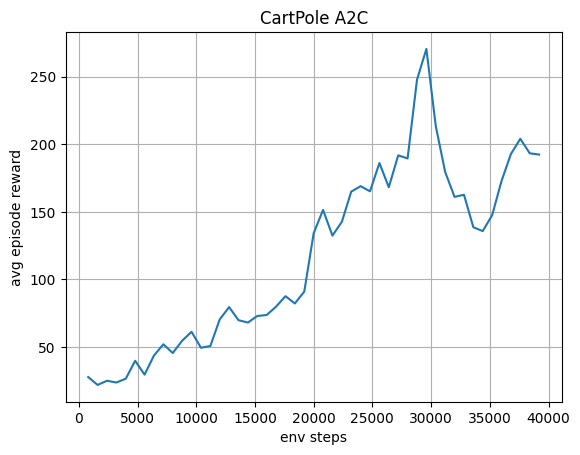

In [79]:
plot_curve('cartpole_a2c/log.txt', 'CartPole A2C')

Now let's play a little bit with the trained agent. The neural net parameters are saved to the `cartpole_dqn` and `cartpole_a2c` folders. The cell below will show one episode play.

In [81]:
import time, Algo
# import gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, './video')
agent = Algo.ActorCritic(env.observation_space, env.action_space)
agent.load('cartpole_a2c/9999.pth')
state = env.reset()[0]
env.start_video_recorder()

for _ in tqdm(range(500)):
    # env.render()
    state, reward, done, *_ = env.step(agent.act(state))

    if done:
      env.close_video_recorder()
      break

    time.sleep(0.1)
    # ipythondisplay.clear_output(wait=True)
env.close()

observation shape = (4,), action shape = ().
shared net = False, parameters to optimize: [('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([2, 128]), True), ('fc2.bias', torch.Size([2]), True), ('fc1.weight', torch.Size([128, 4]), True), ('fc1.bias', torch.Size([128]), True), ('fc2.weight', torch.Size([1, 128]), True), ('fc2.bias', torch.Size([1]), True)] 

Moviepy - Building video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4



t:   0%|          | 0/1 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4


 28%|██▊       | 138/500 [00:14<00:38,  9.46it/s]

Moviepy - Building video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4



 28%|██▊       | 138/500 [00:14<00:39,  9.26it/s]


Moviepy - Done !
Moviepy - video ready /Users/jelmerbennema/Documents/Oxford/MSc/Hilary/Deep Learning/HW4_Deep_Learning/video/rl-video-episode-0.mp4


In [82]:
show_video()